In [ ]:
%matplotlib inline

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 8.1 MB/s eta 0:00:00


Translation with a Sequence to Sequence Network
*************************************************************

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__


**Requirements**



Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site http://tatoeba.org/ which has
downloads available at http://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip -o fra-eng.zip
!mkdir data
!mv fra.txt data/eng-fra.txt

--2023-04-10 01:15:45--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7420323 (7.1M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.08M  17.2MB/s    in 0.4s    

2023-04-10 01:15:46 (17.2 MB/s) - ‘fra-eng.zip’ saved [7420323/7420323]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import matplotlib.pyplot as plt
import math
import os

SOS_token = 0 # Start of sentence
EOS_token = 1 # End of sentence


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:           # if <word> is not in vocab
            self.word2index[word] = self.n_words    # give current index to new <word>
            self.word2count[word] = 1               # give 1 to the number of times <word> appeared thus far
            self.index2word[self.n_words] = word    # add <word> to vocab
            self.n_words += 1                       # increase number of words in vocab by 1
        else:                                     # if <word> is in vocab
            self.word2count[word] += 1
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [ ]:
MAX_LENGTH = 15

eng_prefixes = (
    "i am", "i m",
    "he is", "he s",
    "she is", "she s",
    "you are", "you re",
    "we are", "we re",
    "they are", "they re"
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
#print(random.choice(pairs))

Reading lines...
Read 217975 sentence pairs
Trimmed to 21527 sentence pairs
Counting words...
Counted words:
fra 6845
eng 4496


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = [i[0] for i in pairs]
y = [i[1] for i in pairs]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train_pairs = list(zip(X_train,y_train))
test_pairs = list(zip(X_test,y_test))

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.






In [ ]:
##### Original ##### Task 2 & 5

# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size)

#     def forward(self, input, hidden):
#         embedded = self.embedding(input).view(1, 1, -1) # [1, batch_size, hidden_size]
#         output = embedded
#         output, hidden = self.gru(output, hidden)
#         return output, hidden # [1, batch_size, hidden_size], [1, batch_size, hidden_size]

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)


##### LSTM ##### Task 3

# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.lstm = nn.LSTM(hidden_size, hidden_size)

#     def forward(self, input, hidden, cell):
#         embedded = self.embedding(input).view(1, 1, -1)
#         output = embedded
#         output, (hidden, cell) = self.lstm(output, (hidden, cell)) # [input_size, batch_size, hidden_size], ([1, batch_size, hidden_size], [1, batch_size, hidden_size])
#         return output, (hidden, cell)

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

##### bi-LSTM ##### Task 4

# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True)

#     def forward(self, input, hidden, cell):
#         embedded = self.embedding(input).view(1, 1, -1)
#         output = embedded # [input_size, batch_size, 2*hidden_size]
#         output, (hidden, cell) = self.lstm(output, (hidden, cell)) 
#         return output, (hidden, cell) # [input_size, batch_size, 2*hidden_size], ([2, batch_size, hidden_size], [2, batch_size, hidden_size])

#     def initHidden(self):
#         return torch.zeros(2, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(2, 1, self.hidden_size, device=device)

##### TransformerEncoder ##### Task 6

class PositionalEncoding(nn.Module):

    def __init__(self, input_size, dropout=0.1, max_len=MAX_LENGTH):
        super().__init__()
        # self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_size, 2) * (-math.log(10000.0) / input_size))
        pe = torch.zeros(max_len, 1, input_size)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        # return self.dropout(x)
        return x

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        self.tel = nn.TransformerEncoderLayer(hidden_size, nhead=2, dim_feedforward=hidden_size)
        self.te = nn.TransformerEncoder(self.tel, num_layers=2)
        # initial nhead=2, num_layers=2
        # 2nd: nhead=4, num_layers=12


    def forward(self, input):
        embedded = self.embedding(input).view(1, 1, -1) # [1, batch_size, hidden_size]
        output = embedded
        # output, hidden = self.gru(output, hidden)
        output = self.pos_encoder(output)
        output = self.te(output)

        return output # [1, batch_size, hidden_size]

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def initCell(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)



The Decoder (Your assignment)
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).


In [ ]:
##### Original ##### Task 2 & 6

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        # Your code here #
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

##### LSTM ##### Task 3

# class Decoder(nn.Module):
#     def __init__(self, hidden_size, output_size):
#         super(Decoder, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(output_size, hidden_size)
#         self.lstm = nn.LSTM(hidden_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden, cell):

#         # Your code here #
#         output = self.embedding(input).view(1, 1, -1)
#         output = F.relu(output)
#         output, (hidden, cell) = self.lstm(output, (hidden, cell)) # [input_size, batch_size, hidden_size], ([1, batch_size, hidden_size], [1, batch_size, hidden_size])
#         output = self.softmax(self.out(output[0]))
#         return output, (hidden, cell)

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

##### bi-LSTM ##### Task 4

# class Decoder(nn.Module):
#     def __init__(self, hidden_size, output_size):
#         super(Decoder, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(output_size, 2*hidden_size)
#         self.gru = nn.GRU(2*hidden_size, 2*hidden_size)
#         self.out = nn.Linear(2*hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):

#         # Your code here #
#         output = self.embedding(input).view(1, 1, -1) # [1, batch_size, 2*hidden_size]
#         output = F.relu(output)
#         output, hidden = self.gru(output, hidden) # [input_size, batch_size, 2*hidden_size], [2, batch_size, hidden_size]
#         output = self.softmax(self.out(output[0]))
#         return output, hidden # [input_size, batch_size, 2*hidden_size], [2, batch_size, hidden_size]

#     def initHidden(self):
#         return torch.zeros(2, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(2, 1, self.hidden_size, device=device)


##### Attention ##### Task 5

# class Decoder(nn.Module):
#     def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
#         super(Decoder, self).__init__()
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         # self.dropout_p = dropout_p
#         self.max_length = max_length

#         self.embedding = nn.Embedding(self.output_size, self.hidden_size)
#         self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
#         self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
#         # self.dropout = nn.Dropout(self.dropout_p)
#         self.gru = nn.GRU(self.hidden_size, self.hidden_size)
#         self.out = nn.Linear(self.hidden_size, self.output_size)

#     def forward(self, input, hidden, encoder_hiddens):
#       # hidden = [1, batch_size, hidden_size]
#       # encoder_hiddens = [max_length, hidden_size]
#         embedded = self.embedding(input).view(1, 1, -1) # [1, batch_size, hidden_size]
#         # embedded = self.dropout(embedded) # [1, batch_size, hidden_size]

#         attn_scores = torch.mm(hidden[0], torch.transpose(encoder_hiddens, 0, 1)) # [batch_size, max_length]
#         attn_distribution = F.softmax(attn_scores, dim=1) # [batch_size, max_length]
#         attn_outputs = torch.mm(attn_distribution, encoder_hiddens) # [batch_size, hidden_size]
#         attn_outputs = attn_outputs.unsqueeze(0) # [1, batch_size, hidden_size]

#         output = torch.cat((embedded[0], attn_outputs[0]), 1) # [batch_size, 2*hidden_size]
#         output = self.attn_combine(output).unsqueeze(0) # [1, batch_size, hidden_size]

#         output = F.relu(output)
#         output, hidden = self.gru(output, hidden)

#         output = F.log_softmax(self.out(output[0]), dim=1)
#         return output, hidden, attn_distribution

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

# Transformer Encoder/Decoder

In [ ]:
# class PositionalEncoding(nn.Module):

#     def __init__(self, input_size, dropout=0.1, max_len=MAX_LENGTH):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, input_size, 2) * (-math.log(10000.0) / input_size))
#         pe = torch.zeros(max_len, 1, input_size)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
#         """
#         x = x + self.pe[:x.size(0)]
#         return self.dropout(x)

# class TransformerModel(nn.Module):

#     def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.5):
#         super().__init__()
#         self.model_type = 'Transformer'
#         self.pos_encoder = PositionalEncoding(d_model, dropout)
#         encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
#         self.encoder = nn.Embedding(ntoken, d_model)
#         self.d_model = d_model
#         self.decoder = nn.Linear(d_model, ntoken)

#         self.init_weights()

#     def init_weights(self) -> None:
#         initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
#         self.decoder.bias.data.zero_()
#         self.decoder.weight.data.uniform_(-initrange, initrange)

#     def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
#         """
#         Args:
#             src: Tensor, shape [seq_len, batch_size]
#             src_mask: Tensor, shape [seq_len, seq_len]

#         Returns:
#             output Tensor of shape [seq_len, batch_size, ntoken]
#         """
#         src = self.encoder(src) * math.sqrt(self.d_model)
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src, src_mask)
#         output = self.decoder(output)
#         return output


# def generate_square_subsequent_mask(sz: int) -> Tensor:
#     """Generates an upper-triangular matrix of -inf, with zeros on diag."""
#     return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder.initCell()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    # encoder_outputs = torch.zeros(max_length, 2*encoder.hidden_size, device=device) ##### bi-LSTM ##### Task 4
    # encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device) ##### Attention ##### Task 5

    loss = 0

    for ei in range(input_length):
        # encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden) ##### Original ##### Task 2 & 5
        # encoder_output, (encoder_hidden, encoder_cell)  = encoder(input_tensor[ei], encoder_hidden, encoder_cell) #### LSTM ##### Task 3
        # encoder_output, (encoder_hidden, encoder_cell)  = encoder(input_tensor[ei], encoder_hidden, encoder_cell) #### LSTM ##### Task 4
        encoder_output = encoder(input_tensor[ei]) ##### Transformer ##### Task 6

        encoder_outputs[ei] = encoder_output[0, 0]
        # encoder_hiddens[ei] = encoder_hidden[0, 0] ##### Attention ##### Task 5

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    # decoder_hidden = torch.reshape(decoder_hidden, (1,1,2*decoder_hidden.shape[2])) ##### bi-LSTM ##### Task 4
    # decoder_cell = encoder_cell ##### LSTM ##### Task 3
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### Original ##### Task 2 & 6
            # decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell) ##### LSTM ##### Task 3
            # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### LSTM ##### Task 4
            # decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens) ##### Attention ##### Task 5

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### Original ##### Task 2 & 6
            # decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell) ##### LSTM ##### Task 3
            # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### bi-LSTM ##### Task 4
            # decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens) ##### Attention ##### Task 5

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
def trainIters(encoder, decoder, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    iter = 1
    n_iters = len(train_pairs) * epochs

    for epoch in range(epochs):
        print("Epoch: %d/%d" % (epoch, epochs))
        for training_pair in train_pairs:
            training_pair = tensorsFromPair(training_pair)

            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                            iter, iter / n_iters * 100, print_loss_avg))
                
            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

            iter +=1

    # Plot training Curves
    plt.figure(figsize=(12,16))
    plt.plot(plot_losses)
    plt.ylim((0,max(plot_losses)))
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    return plot_losses


Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder.initCell()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        # encoder_outputs = torch.zeros(max_length, 2*encoder.hidden_size, device=device) ##### bi-LSTM ##### Task 4
        # encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device) ##### Attention ##### Task 5

        for ei in range(input_length):
            # encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden) ##### Original ##### Task 2 & 5
            # encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], encoder_hidden, encoder_cell) ##### LSTM ##### Task 3
            # encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], encoder_hidden, encoder_cell) ##### bi-LSTM ##### Task 4
            encoder_output = encoder(input_tensor[ei]) ##### Transformer ##### Task 6

            encoder_outputs[ei] += encoder_output[0, 0]
            # encoder_hiddens[ei] = encoder_hidden[0, 0] ##### Attention ##### Task 5

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        # decoder_hidden = torch.reshape(decoder_hidden, (1,1,2*decoder_hidden.shape[2])) ##### bi-LSTM ##### Task 4
        # decoder_cell = encoder_cell ##### LSTM ##### Task 3

        decoded_words = []
        # decoder_attentions = torch.zeros(max_length, max_length) ##### Attention ##### Task 5

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### Original ##### Task 2 & 6
            # decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell) ##### LSTM ##### Task 3
            # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### bi-LSTM ##### Task 4
            # decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens) ##### Attention ##### Task 5

            # decoder_attentions[di] = decoder_attention.data ##### Attention ##### Task 5
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words
        # return decoded_words, decoder_attentions[:di + 1] ##### Attention ##### Task 5

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        # output_words, attentions = evaluate(encoder, decoder, pair[0]) ##### Attention ##### Task 5
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
import numpy as np
from torchmetrics.text.rouge import ROUGEScore
from tqdm import tqdm

rouge = ROUGEScore()

def test(encoder, decoder, testing_pairs):
    input = []
    gt = []
    predict = []
    metric_score = {
        "rouge1_fmeasure":[],
        "rouge1_precision":[],
        "rouge1_recall":[],
        "rouge2_fmeasure":[],
        "rouge2_precision":[],
        "rouge2_recall":[]
    }

    for i in tqdm(range(len(testing_pairs))):
        pair = testing_pairs[i]
        output_words = evaluate(encoder, decoder, pair[0])
        # output_words, attentions = evaluate(encoder, decoder, pair[0]) ##### Attention ##### Task 5
        output_sentence = ' '.join(output_words)

        input.append(pair[0])
        gt.append(pair[1])
        predict.append(output_sentence)

        try:
            rs = rouge(output_sentence, pair[1])
        except:
            continue
        metric_score["rouge1_fmeasure"].append(rs['rouge1_fmeasure'])
        metric_score["rouge1_precision"].append(rs['rouge1_precision'])
        metric_score["rouge1_recall"].append(rs['rouge1_recall'])
        metric_score["rouge2_fmeasure"].append(rs['rouge2_fmeasure'])
        metric_score["rouge2_precision"].append(rs['rouge2_precision'])
        metric_score["rouge2_recall"].append(rs['rouge2_recall'])
        
    metric_score["rouge1_fmeasure"] = np.array(metric_score["rouge1_fmeasure"]).mean()
    metric_score["rouge1_precision"] = np.array(metric_score["rouge1_precision"]).mean()
    metric_score["rouge1_recall"] = np.array(metric_score["rouge1_recall"]).mean()
    metric_score["rouge2_fmeasure"] = np.array(metric_score["rouge2_fmeasure"]).mean()
    metric_score["rouge2_precision"] = np.array(metric_score["rouge2_precision"]).mean()
    metric_score["rouge2_recall"] = np.array(metric_score["rouge2_recall"]).mean()

    print("=== Evaluation score - Rouge score ===")
    print("Rouge1 fmeasure:\t",metric_score["rouge1_fmeasure"])
    print("Rouge1 precision:\t",metric_score["rouge1_precision"])
    print("Rouge1 recall:  \t",metric_score["rouge1_recall"])
    print("Rouge2 fmeasure:\t",metric_score["rouge2_fmeasure"])
    print("Rouge2 precision:\t",metric_score["rouge2_precision"])
    print("Rouge2 recall:  \t",metric_score["rouge2_recall"])
    print("=====================================")
    return input,gt,predict,metric_score

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




Epoch: 0/10
1m 51s (- 62m 16s) (5000 2%) 3.4746
3m 41s (- 59m 51s) (10000 5%) 3.2300
5m 32s (- 58m 9s) (15000 8%) 3.1515
Epoch: 1/10
7m 24s (- 56m 26s) (20000 11%) 3.0894
9m 14s (- 54m 27s) (25000 14%) 3.0067
11m 5s (- 52m 34s) (30000 17%) 3.0077
Epoch: 2/10
12m 57s (- 50m 49s) (35000 20%) 2.9455
14m 48s (- 48m 57s) (40000 23%) 2.9084
16m 39s (- 47m 6s) (45000 26%) 2.8963
18m 30s (- 45m 15s) (50000 29%) 2.8708
Epoch: 3/10
20m 24s (- 43m 29s) (55000 31%) 2.8344
22m 15s (- 41m 38s) (60000 34%) 2.7853
24m 6s (- 39m 46s) (65000 37%) 2.8379
Epoch: 4/10
25m 57s (- 37m 53s) (70000 40%) 2.7945
27m 46s (- 35m 59s) (75000 43%) 2.7172
29m 35s (- 34m 6s) (80000 46%) 2.7601
31m 25s (- 32m 14s) (85000 49%) 2.7239
Epoch: 5/10
33m 14s (- 30m 22s) (90000 52%) 2.7071
35m 3s (- 28m 29s) (95000 55%) 2.7239
36m 53s (- 26m 38s) (100000 58%) 2.7027
Epoch: 6/10
38m 43s (- 24m 47s) (105000 60%) 2.6722
40m 32s (- 22m 55s) (110000 63%) 2.6561
42m 22s (- 21m 4s) (115000 66%) 2.6493
44m 12s (- 19m 14s) (120000 69%

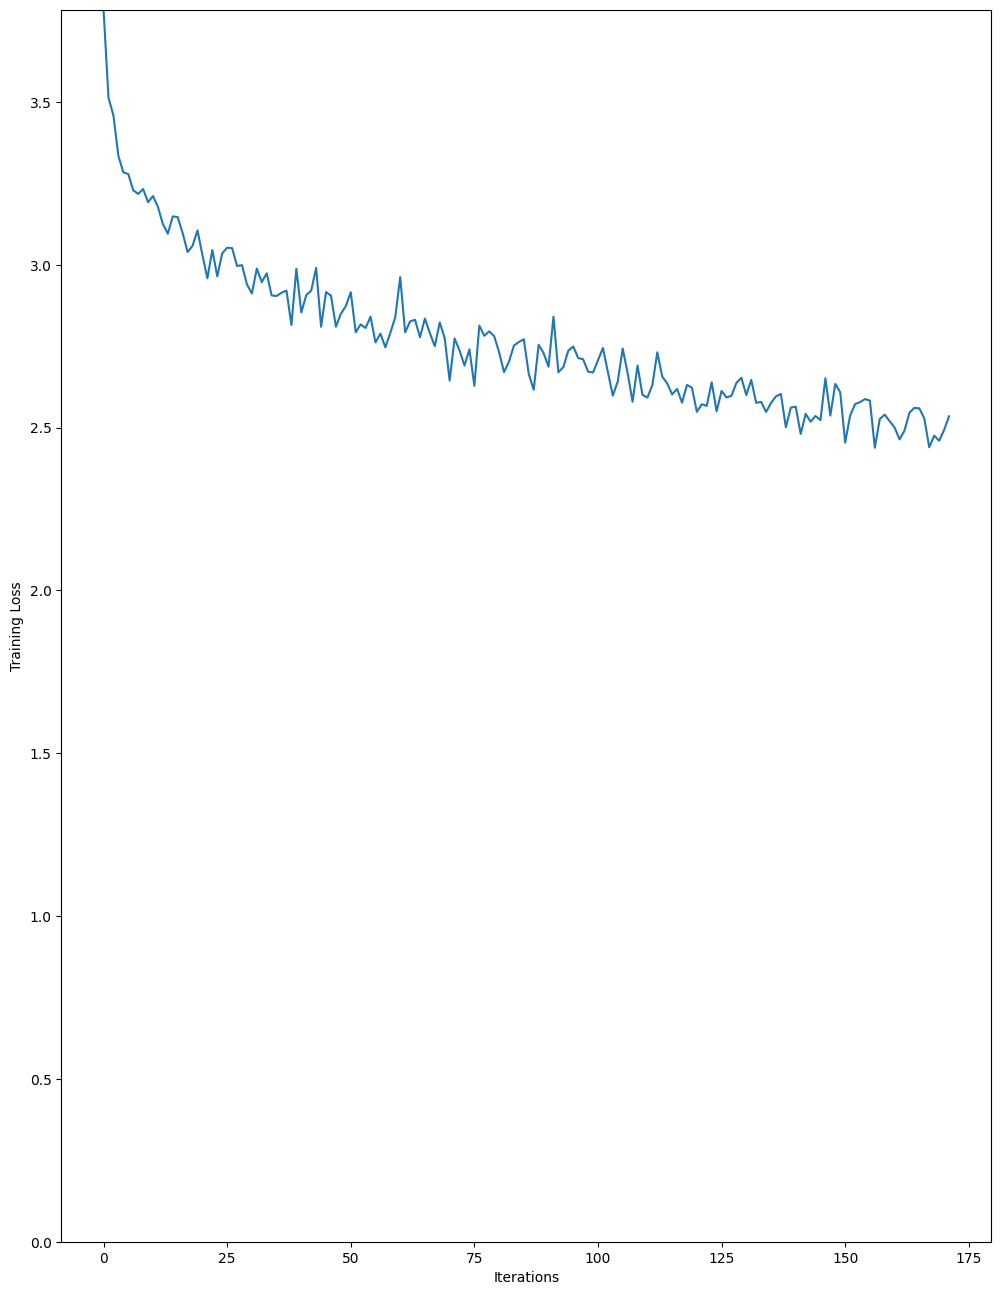

In [ ]:
hidden_size = 512 # Original 512, To try 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

task6_losses = trainIters(encoder1, decoder1, 10, print_every=5000, plot_every=1000) 

In [ ]:
evaluateRandomly(encoder1, decoder1)

> je vais trouver quelque chose .
= i m going to think of something .
< i m not . <EOS>

> je me fais du soucis par rapport a la securite de tom .
= i m concerned with tom s safety .
< i m not . <EOS>

> je n ai pas faim du tout .
= i m not hungry at all .
< i m not . <EOS>

> c est un avocat competent .
= he is a capable lawyer .
< i m not . <EOS>

> il est poissonnier .
= he is a fishmonger .
< i m not . <EOS>

> je suis photographe .
= i m a photographer .
< i m not . <EOS>

> j en ai marre qu il me fasse tout le temps la morale .
= i m fed up with him always preaching to me .
< i m not . <EOS>

> il est impatient d y aller .
= he is eager to go there .
< i m not . <EOS>

> j en ai ras le bol d ecouter ses recriminations .
= i m sick of listening to her complaints .
< i m not . <EOS>

> je commence a comprendre pourquoi tom aime boston .
= i m beginning to understand why tom loves boston .
< i m not . <EOS>



In [ ]:
input,gt,predict,score = test(encoder1, decoder1, train_pairs)

100%|██████████| 17221/17221 [02:41<00:00, 106.55it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.8669647
Rouge1 precision:	 0.7971948
Rouge1 recall:  	 0.9537548
Rouge2 fmeasure:	 0.80207396
Rouge2 precision:	 0.7245477
Rouge2 recall:  	 0.9041542


In [ ]:
input,gt,predict,score = test(encoder1, decoder1, test_pairs)

100%|██████████| 4306/4306 [00:38<00:00, 110.61it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.679606
Rouge1 precision:	 0.62672544
Rouge1 recall:  	 0.75115275
Rouge2 fmeasure:	 0.511453
Rouge2 precision:	 0.46357793
Rouge2 recall:  	 0.57932574


In [ ]:
print(train_pairs[0][1])
print(train_pairs[0][0])

i m a member of the team .
je suis membre de l equipe .


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# print(task2_losses)
# '''
# [3.728420750224086, 3.3582383695894844, 3.208555665999341, 3.0032104547986056, 2.8930696103994653, 2.8027955672465534, 2.7077022335729346, 
# 2.614408709541783, 2.585856303221995, 2.503114588997289, 2.385469212712832, 2.373945713548809, 2.2523577769872674, 2.242437818531863, 2.28279455701242, 
# 2.236246579296538, 2.1332715246508385, 2.0746267100272764, 2.029553967020177, 2.003722545700375, 1.9675006362724452, 1.8725920899217634, 1.8490630699188138, 
# 1.8277227000928895, 1.782340917409531, 1.7429985314972578, 1.7146596493192658, 1.6463125614656997, 1.6324497297242313, 1.594952741398016, 1.5544393851960443, 
# 1.6025474629567482, 1.59518772574131, 1.5292953309107287, 1.468349747784364, 1.433569935770425, 1.4621782720409418, 1.4270558838179963, 1.3454977894240627, 
# 1.3600030629486928, 1.300652371080223, 1.3008228544548854, 1.291891465921885, 1.2442242876194132, 1.201333210578322, 1.1293421018940029, 1.132829770885435, 
# 1.136621304797383, 1.1687046667655983, 1.1572561910943855, 1.1166885295899098, 1.1055007803442174, 1.0143164373523823, 1.1191433988027994, 1.0312222293519624, 
# 0.9996575453736631, 0.981647142018276, 1.0241138446911677, 0.9567882643505838, 0.9361646974245932, 0.9727222233189909, 0.8922128169266461, 0.8590776264776593, 
# 0.8473105717530385, 0.8308460448304402, 0.8810404347161246, 0.8556850585437218, 0.8563982012986269, 0.849008482565189, 0.8068530649893292, 0.7978995859246442, 
# 0.8103370070645524, 0.7843036119688184, 0.755170441585674, 0.7592687062446726, 0.7609735867516125, 0.7073121259954608, 0.734015305840326, 0.6874103399655804, 
# 0.692163324857092, 0.6496684262754832, 0.6560181590533983, 0.6696728759059584, 0.6757650027037728, 0.6769010320826722, 0.6587894797640134, 0.6310368942384114, 
# 0.609933757725875, 0.6318353793693142, 0.6318079090344727, 0.6041901735129694, 0.575512717027929, 0.5759527929188875, 0.5718203023591861, 0.5466570002336919, 
# 0.542653290983125, 0.5231786884179348, 0.49136340557469016, 0.5045958823623926, 0.5223402243138385, 0.5009186018762724, 0.5454272262195498, 0.5304610812023101, 
# 0.47360607315261216, 0.4871438903676429, 0.4862196607179997, 0.4594664874798356, 0.49126337218221416, 0.46464821838121045, 0.4325445292444593, 0.44622404982842684, 
# 0.4912660341381161, 0.4607663172219618, 0.4308497649028291, 0.4112131932511522, 0.39733545859710123, 0.4049679371580424, 0.40714711406951265, 0.44061939005199435, 
# 0.44219634403435937, 0.4309344640819733, 0.3832604959759044, 0.4186701305321601, 0.40193071808723796, 0.3794193449685887, 0.38071890168196915, 0.35465837567242275, 
# 0.3368561560258915, 0.38787785933778507, 0.38847607102940945, 0.3835734445222217, 0.3453889634373569, 0.31027869990425777, 0.3594663042165803, 0.3555766860829228, 
# 0.3671311095005316, 0.36676640589290327, 0.35336158262779105, 0.3135020286399016, 0.35807483024239944, 0.33392918584184494, 0.30168838766652656, 0.30759555949705925, 
# 0.3107344739279075, 0.2741595767608546, 0.31328052657196664, 0.3244393346396621, 0.3104521866115775, 0.31053858651388855, 0.27447306759296414, 0.27146987836167796, 
# 0.29782389205251775, 0.28058647145229176, 0.3065924283034136, 0.2772817794117212, 0.30411807841248045, 0.2804567337452445, 0.2836131384880793, 0.3025347914328551, 
# 0.2864875862524861, 0.2769769667013224, 0.25251014923232484, 0.27515448204301945, 0.29410365024564533, 0.24117178662038358, 0.2836980721042539, 0.24751890283745165, 
# 0.2735165314192525, 0.26394127966095543, 0.2465544083019008, 0.2732734098937558, 0.2519009005706947]
# '''

task2_losses = np.array([3.728420750224086, 3.3582383695894844, 3.208555665999341, 3.0032104547986056, 2.8930696103994653, 2.8027955672465534, 2.7077022335729346, 2.614408709541783, 2.585856303221995, 2.503114588997289, 2.385469212712832, 2.373945713548809, 2.2523577769872674, 2.242437818531863, 2.28279455701242, 2.236246579296538, 2.1332715246508385, 2.0746267100272764, 2.029553967020177, 2.003722545700375, 1.9675006362724452, 1.8725920899217634, 1.8490630699188138, 1.8277227000928895, 1.782340917409531, 1.7429985314972578, 1.7146596493192658, 1.6463125614656997, 1.6324497297242313, 1.594952741398016, 1.5544393851960443, 1.6025474629567482, 1.59518772574131, 1.5292953309107287, 1.468349747784364, 1.433569935770425, 1.4621782720409418, 1.4270558838179963, 1.3454977894240627, 1.3600030629486928, 1.300652371080223, 1.3008228544548854, 1.291891465921885, 1.2442242876194132, 1.201333210578322, 1.1293421018940029, 1.132829770885435, 1.136621304797383, 1.1687046667655983, 1.1572561910943855, 1.1166885295899098, 1.1055007803442174, 1.0143164373523823, 1.1191433988027994, 1.0312222293519624, 0.9996575453736631, 0.981647142018276, 1.0241138446911677, 0.9567882643505838, 0.9361646974245932, 0.9727222233189909, 0.8922128169266461, 0.8590776264776593, 0.8473105717530385, 0.8308460448304402, 0.8810404347161246, 0.8556850585437218, 0.8563982012986269, 0.849008482565189, 0.8068530649893292, 0.7978995859246442, 0.8103370070645524, 0.7843036119688184, 0.755170441585674, 0.7592687062446726, 0.7609735867516125, 0.7073121259954608, 0.734015305840326, 0.6874103399655804, 0.692163324857092, 0.6496684262754832, 0.6560181590533983, 0.6696728759059584, 0.6757650027037728, 0.6769010320826722, 0.6587894797640134, 0.6310368942384114, 0.609933757725875, 0.6318353793693142, 0.6318079090344727, 0.6041901735129694, 0.575512717027929, 0.5759527929188875, 0.5718203023591861, 0.5466570002336919, 0.542653290983125, 0.5231786884179348, 0.49136340557469016, 0.5045958823623926, 0.5223402243138385, 0.5009186018762724, 0.5454272262195498, 0.5304610812023101, 0.47360607315261216, 0.4871438903676429, 0.4862196607179997, 0.4594664874798356, 0.49126337218221416, 0.46464821838121045, 0.4325445292444593, 0.44622404982842684, 0.4912660341381161, 0.4607663172219618, 0.4308497649028291, 0.4112131932511522, 0.39733545859710123, 0.4049679371580424, 0.40714711406951265, 0.44061939005199435, 0.44219634403435937, 0.4309344640819733, 0.3832604959759044, 0.4186701305321601, 0.40193071808723796, 0.3794193449685887, 0.38071890168196915, 0.35465837567242275, 0.3368561560258915, 0.38787785933778507, 0.38847607102940945, 0.3835734445222217, 0.3453889634373569, 0.31027869990425777, 0.3594663042165803, 0.3555766860829228, 0.3671311095005316, 0.36676640589290327, 0.35336158262779105, 0.3135020286399016, 0.35807483024239944, 0.33392918584184494, 0.30168838766652656, 0.30759555949705925, 0.3107344739279075, 0.2741595767608546, 0.31328052657196664, 0.3244393346396621, 0.3104521866115775, 0.31053858651388855, 0.27447306759296414, 0.27146987836167796, 0.29782389205251775, 0.28058647145229176, 0.3065924283034136, 0.2772817794117212, 0.30411807841248045, 0.2804567337452445, 0.2836131384880793, 0.3025347914328551, 0.2864875862524861, 0.2769769667013224, 0.25251014923232484, 0.27515448204301945, 0.29410365024564533, 0.24117178662038358, 0.2836980721042539, 0.24751890283745165, 0.2735165314192525, 0.26394127966095543, 0.2465544083019008, 0.2732734098937558, 0.2519009005706947])


In [ ]:
# print(task3_losses)
# '''
# [3.7816378778191293, 3.458290675989241, 3.2586246863263026, 3.138302357663968, 3.047785634644274, 3.056209658214768, 2.971228612798514, 
# 2.9595190233680455, 2.9421280244033774, 2.8382453585101337, 2.7345404266326088, 2.733542565916257, 2.6140098475350864, 2.593162137780461, 
# 2.6373415320516376, 2.5676129563909016, 2.505851388734528, 2.4177176955456847, 2.386387424799263, 2.4027161433095103, 2.361792336935473, 
# 2.2973786389619124, 2.251783874775266, 2.2193474187659734, 2.1956595640396026, 2.190391191432025, 2.142298664046267, 2.051148715082574, 
# 2.056457648175091, 2.022537450973888, 1.9614694179477452, 2.062040933743995, 2.023547952114322, 1.9528039118359743, 1.882304586685375, 
# 1.8866178118697152, 1.899320436877808, 1.8494341175808418, 1.8235599319267264, 1.8305412773829475, 1.7292463178664423, 1.7416701824022973, 
# 1.7624751411276594, 1.7565131909016467, 1.6768169992706707, 1.6231554438868625, 1.6023784003546937, 1.5883580340447216, 1.609094075920421, 
# 1.6468294352043118, 1.5834670335461556, 1.5459363529090289, 1.4919461486357195, 1.5255384035119426, 1.491721661611783, 1.4562799757539877, 
# 1.4290806839819175, 1.4575504159918466, 1.3810135890280677, 1.4258918369789044, 1.4407776134949863, 1.306087478197364, 1.2888003995364476, 
# 1.296115033972883, 1.282007884977388, 1.3025322455779018, 1.3299483778903485, 1.2514253738993921, 1.2537905393490154, 1.208400917906471, 
# 1.2147655878443675, 1.1815428449082743, 1.1807854067366332, 1.1786091197183293, 1.1337893555174967, 1.1308977517337622, 1.1229277575467103, 
# 1.1184851607473525, 1.0978654739616618, 1.035547814848225, 1.071175975786209, 1.0360430367579032, 1.0374460540860067, 1.0223449521252044, 
# 1.0407998015038995, 1.035081101231201, 0.9544281082350619, 0.9562561455177908, 0.9579558782382034, 0.9447831459960905, 0.9350376994057379, 
# 0.9387849424536636, 0.9268721445068784, 0.9198825072433032, 0.8739871012569874, 0.8992101099729455, 0.8355319296221261, 0.8253697783046454, 
# 0.8092922192957718, 0.841943510746363, 0.817011608368272, 0.8281485459117875, 0.815601639048638, 0.7760138964718639, 0.7497153783414717, 
# 0.798584268666979, 0.7188328156653732, 0.7720497179995185, 0.7322277213482934, 0.6978696629389151, 0.696272748327405, 0.7216408141173454, 
# 0.737756475129112, 0.6747899191226823, 0.6773247884499967, 0.6262750920009258, 0.6368244155303842, 0.6621009220682881, 0.6463675953973229, 
# 0.6466708527476859, 0.6110228447207308, 0.602316293724545, 0.6088137750613336, 0.575009946103469, 0.5836953080050192, 0.5744378278905805, 
# 0.5630137416874096, 0.5385427460015011, 0.5887285447318993, 0.5816858662010369, 0.523371573444443, 0.5144735252062144, 0.506858678186835, 
# 0.49698590523614433, 0.5083947821550994, 0.49666358118516923, 0.4992118951000694, 0.47828654000188026, 0.4503715559593495, 0.46844630881836535, 
# 0.4642872968193559, 0.46462012342396397, 0.44579325954675314, 0.4366125179786239, 0.4162026860613103, 0.4431383366826676, 0.46479215003147184, 
# 0.42024417948730736, 0.3759082854465251, 0.38054992021176975, 0.39425062040841435, 0.41598333945152177, 0.39604215290554223, 0.40531393116453457, 
# 0.3354650607718858, 0.33346305628753553, 0.3545389674917834, 0.3720796751700879, 0.3365910098932602, 0.32723429233578377, 0.32851157998554004, 
# 0.2909073160943675, 0.33513866327191244, 0.3228444643976811, 0.34084131717417404, 0.29596700541998083, 0.2897607174916099, 0.28317452371922064, 
# 0.2878614433456244, 0.27430996202209046, 0.3085198319887127, 0.2774687246884904]
# '''

task3_losses = np.array([3.7816378778191293, 3.458290675989241, 3.2586246863263026, 3.138302357663968, 3.047785634644274, 3.056209658214768, 2.971228612798514, 2.9595190233680455, 2.9421280244033774, 2.8382453585101337, 2.7345404266326088, 2.733542565916257, 2.6140098475350864, 2.593162137780461, 2.6373415320516376, 2.5676129563909016, 2.505851388734528, 2.4177176955456847, 2.386387424799263, 2.4027161433095103, 2.361792336935473, 2.2973786389619124, 2.251783874775266, 2.2193474187659734, 2.1956595640396026, 2.190391191432025, 2.142298664046267, 2.051148715082574, 2.056457648175091, 2.022537450973888, 1.9614694179477452, 2.062040933743995, 2.023547952114322, 1.9528039118359743, 1.882304586685375, 1.8866178118697152, 1.899320436877808, 1.8494341175808418, 1.8235599319267264, 1.8305412773829475, 1.7292463178664423, 1.7416701824022973, 1.7624751411276594, 1.7565131909016467, 1.6768169992706707, 1.6231554438868625, 1.6023784003546937, 1.5883580340447216, 1.609094075920421, 1.6468294352043118, 1.5834670335461556, 1.5459363529090289, 1.4919461486357195, 1.5255384035119426, 1.491721661611783, 1.4562799757539877, 1.4290806839819175, 1.4575504159918466, 1.3810135890280677, 1.4258918369789044, 1.4407776134949863, 1.306087478197364, 1.2888003995364476, 1.296115033972883, 1.282007884977388, 1.3025322455779018, 1.3299483778903485, 1.2514253738993921, 1.2537905393490154, 1.208400917906471, 1.2147655878443675, 1.1815428449082743, 1.1807854067366332, 1.1786091197183293, 1.1337893555174967, 1.1308977517337622, 1.1229277575467103, 1.1184851607473525, 1.0978654739616618, 1.035547814848225, 1.071175975786209, 1.0360430367579032, 1.0374460540860067, 1.0223449521252044, 1.0407998015038995, 1.035081101231201, 0.9544281082350619, 0.9562561455177908, 0.9579558782382034, 0.9447831459960905, 0.9350376994057379, 0.9387849424536636, 0.9268721445068784, 0.9198825072433032, 0.8739871012569874, 0.8992101099729455, 0.8355319296221261, 0.8253697783046454, 0.8092922192957718, 0.841943510746363, 0.817011608368272, 0.8281485459117875, 0.815601639048638, 0.7760138964718639, 0.7497153783414717, 0.798584268666979, 0.7188328156653732, 0.7720497179995185, 0.7322277213482934, 0.6978696629389151, 0.696272748327405, 0.7216408141173454, 0.737756475129112, 0.6747899191226823, 0.6773247884499967, 0.6262750920009258, 0.6368244155303842, 0.6621009220682881, 0.6463675953973229, 0.6466708527476859, 0.6110228447207308, 0.602316293724545, 0.6088137750613336, 0.575009946103469, 0.5836953080050192, 0.5744378278905805, 0.5630137416874096, 0.5385427460015011, 0.5887285447318993, 0.5816858662010369, 0.523371573444443, 0.5144735252062144, 0.506858678186835, 0.49698590523614433, 0.5083947821550994, 0.49666358118516923, 0.4992118951000694, 0.47828654000188026, 0.4503715559593495, 0.46844630881836535, 0.4642872968193559, 0.46462012342396397, 0.44579325954675314, 0.4366125179786239, 0.4162026860613103, 0.4431383366826676, 0.46479215003147184, 0.42024417948730736, 0.3759082854465251, 0.38054992021176975, 0.39425062040841435, 0.41598333945152177, 0.39604215290554223, 0.40531393116453457, 0.3354650607718858, 0.33346305628753553, 0.3545389674917834, 0.3720796751700879, 0.3365910098932602, 0.32723429233578377, 0.32851157998554004, 0.2909073160943675, 0.33513866327191244, 0.3228444643976811, 0.34084131717417404, 0.29596700541998083, 0.2897607174916099, 0.28317452371922064, 0.2878614433456244, 0.27430996202209046, 0.3085198319887127, 0.2774687246884904])


In [ ]:
# print(task4_losses)
# '''
# [3.839300659575752, 3.492871327338976, 3.2421299194218585, 3.08060422607157, 2.965797818110847, 2.891099121764204, 2.781972763900481, 
# 2.71760022829403, 2.7013200251476053, 2.6012848900095857, 2.4927024631162475, 2.4209221046859244, 2.3572236887981473, 2.2942071534541038, 
# 2.3478689054746233, 2.286065442359598, 2.2209197425125815, 2.1454682983483515, 2.0855302073940867, 2.1095336044357222, 2.0297050204614324, 
# 1.9738344418466554, 1.9200189507973067, 1.8544623263155948, 1.8443935131080043, 1.8156066913802542, 1.803261384705015, 1.7029170074606779, 
# 1.7066835708159949, 1.6478015987116603, 1.6169289735462629, 1.655870397130447, 1.62828692894665, 1.5722984610045942, 1.5424302690403342, 
# 1.4960793750552632, 1.530085857703955, 1.4790912244936663, 1.4485023453583892, 1.4819121242832822, 1.3590735327304786, 1.3690589802471098, 
# 1.3561878228129123, 1.3160423402700638, 1.26231914689509, 1.2309845319086066, 1.2043538022559988, 1.1968740887734906, 1.2417484705808453, 
# 1.267261762060113, 1.2014915774585042, 1.1738459484967267, 1.1025175105061487, 1.1254026896650982, 1.0867016460199612, 1.0892306067276571, 
# 1.0360301534958611, 1.0601469485479407, 1.0117974613716894, 1.0040051407927242, 1.01122178097116, 0.9570237453568706, 0.9275284206015966, 
# 0.9221114527225983, 0.9013439743240831, 0.9474061968730998, 0.8929292033545699, 0.8942913904674128, 0.8783116666227518, 0.8447999493199214, 
# 0.8992571438728413, 0.8488120120519828, 0.7915403352874205, 0.8113942522794908, 0.7934683002513829, 0.7806726435708864, 0.7428524638625061, 
# 0.7980001995144248, 0.7197535951863385, 0.7127162532277245, 0.7210305946253525, 0.7108261076555191, 0.6666889861213788, 0.7277579473253112, 
# 0.7456330307168594, 0.6808852040361366, 0.665759770326238, 0.6896115693172591, 0.6721168549337918, 0.6198798019965012, 0.6310483097603297, 
# 0.6327733335903407, 0.5943114849277735, 0.5861195370222195, 0.6023624888145479, 0.5881279026242984, 0.5637934684016984, 0.559251160324816, 
# 0.5314759195165105, 0.5511456014204259, 0.5875421004929673, 0.5551061320889188, 0.531132408583466, 0.53949656424937, 0.47944247218349756, 
# 0.5587006102931474, 0.48848346454715424, 0.49543862496355107, 0.47882816523844524, 0.42314233555197445, 0.47525525503163224, 0.4970982967089404, 
# 0.4700744881674212, 0.4663681464921712, 0.4548525766398081, 0.4346038110226077, 0.4384999541096433, 0.44213928862144897, 0.476899419696355, 
# 0.4202840529563694, 0.42425625871656164, 0.4286290177776322, 0.4168388065787026, 0.38680295894969036, 0.3992239818457737, 0.4009328821499378, 
# 0.3862330079131912, 0.38634550382064975, 0.40485450152613606, 0.38477111393956487, 0.37563143788490305, 0.35926771711932565, 0.3283196869492583, 
# 0.3497899419337371, 0.379083183754331, 0.374085607206581, 0.31584426324921844, 0.34941723300551886, 0.32536173972076443, 0.3655132592914722, 
# 0.35255235898858434, 0.34636027976901307, 0.336179081412167, 0.3372358039514882, 0.28951797822699027, 0.3375344629403529, 0.37410583612093706, 
# 0.3366259515384793, 0.32672077087314777, 0.29674328858657617, 0.3127161794825591, 0.3076444230886065, 0.2947218652172181, 0.35038040048589925, 
# 0.27612715564896, 0.28338079795664417, 0.31286619052769565, 0.321130050907679, 0.27729460757336677, 0.2650413930523023, 0.280739882456989, 
# 0.24375246162442046, 0.23293709849949187, 0.2792815572603352, 0.2780167267528709, 0.2739234853087433, 0.26288390155016517, 0.2587642189940267, 
# 0.2658300508810886, 0.25776062187508286, 0.28148473075368236, 0.23174091389247703]
# '''

task4_losses = np.array([3.839300659575752, 3.492871327338976, 3.2421299194218585, 3.08060422607157, 2.965797818110847, 2.891099121764204, 2.781972763900481, 2.71760022829403, 2.7013200251476053, 2.6012848900095857, 2.4927024631162475, 2.4209221046859244, 2.3572236887981473, 2.2942071534541038, 2.3478689054746233, 2.286065442359598, 2.2209197425125815, 2.1454682983483515, 2.0855302073940867, 2.1095336044357222, 2.0297050204614324, 1.9738344418466554, 1.9200189507973067, 1.8544623263155948, 1.8443935131080043, 1.8156066913802542, 1.803261384705015, 1.7029170074606779, 1.7066835708159949, 1.6478015987116603, 1.6169289735462629, 1.655870397130447, 1.62828692894665, 1.5722984610045942, 1.5424302690403342, 1.4960793750552632, 1.530085857703955, 1.4790912244936663, 1.4485023453583892, 1.4819121242832822, 1.3590735327304786, 1.3690589802471098, 1.3561878228129123, 1.3160423402700638, 1.26231914689509, 1.2309845319086066, 1.2043538022559988, 1.1968740887734906, 1.2417484705808453, 1.267261762060113, 1.2014915774585042, 1.1738459484967267, 1.1025175105061487, 1.1254026896650982, 1.0867016460199612, 1.0892306067276571, 1.0360301534958611, 1.0601469485479407, 1.0117974613716894, 1.0040051407927242, 1.01122178097116, 0.9570237453568706, 0.9275284206015966, 0.9221114527225983, 0.9013439743240831, 0.9474061968730998, 0.8929292033545699, 0.8942913904674128, 0.8783116666227518, 0.8447999493199214, 0.8992571438728413, 0.8488120120519828, 0.7915403352874205, 0.8113942522794908, 0.7934683002513829, 0.7806726435708864, 0.7428524638625061, 0.7980001995144248, 0.7197535951863385, 0.7127162532277245, 0.7210305946253525, 0.7108261076555191, 0.6666889861213788, 0.7277579473253112, 0.7456330307168594, 0.6808852040361366, 0.665759770326238, 0.6896115693172591, 0.6721168549337918, 0.6198798019965012, 0.6310483097603297, 0.6327733335903407, 0.5943114849277735, 0.5861195370222195, 0.6023624888145479, 0.5881279026242984, 0.5637934684016984, 0.559251160324816, 0.5314759195165105, 0.5511456014204259, 0.5875421004929673, 0.5551061320889188, 0.531132408583466, 0.53949656424937, 0.47944247218349756, 0.5587006102931474, 0.48848346454715424, 0.49543862496355107, 0.47882816523844524, 0.42314233555197445, 0.47525525503163224, 0.4970982967089404, 0.4700744881674212, 0.4663681464921712, 0.4548525766398081, 0.4346038110226077, 0.4384999541096433, 0.44213928862144897, 0.476899419696355, 0.4202840529563694, 0.42425625871656164, 0.4286290177776322, 0.4168388065787026, 0.38680295894969036, 0.3992239818457737, 0.4009328821499378, 0.3862330079131912, 0.38634550382064975, 0.40485450152613606, 0.38477111393956487, 0.37563143788490305, 0.35926771711932565, 0.3283196869492583, 0.3497899419337371, 0.379083183754331, 0.374085607206581, 0.31584426324921844, 0.34941723300551886, 0.32536173972076443, 0.3655132592914722, 0.35255235898858434, 0.34636027976901307, 0.336179081412167, 0.3372358039514882, 0.28951797822699027, 0.3375344629403529, 0.37410583612093706, 0.3366259515384793, 0.32672077087314777, 0.29674328858657617, 0.3127161794825591, 0.3076444230886065, 0.2947218652172181, 0.35038040048589925, 0.27612715564896, 0.28338079795664417, 0.31286619052769565, 0.321130050907679, 0.27729460757336677, 0.2650413930523023, 0.280739882456989, 0.24375246162442046, 0.23293709849949187, 0.2792815572603352, 0.2780167267528709, 0.2739234853087433, 0.26288390155016517, 0.2587642189940267, 0.2658300508810886, 0.25776062187508286, 0.28148473075368236, 0.23174091389247703])


In [ ]:
# print(task5_losses)
# '''
# [3.793322149632456, 3.3051740363067053, 3.1509306759063986, 2.9999673898161006, 2.904681470231939, 2.819418561050559, 2.70901888326165, 
# 2.678208342990082, 2.624961101683387, 2.5170903758582446, 2.428222503246891, 2.3971668370156687, 2.2953487448503402, 2.2447313600496615, 
# 2.2825043213856553, 2.2665109242413184, 2.1590149287532023, 2.071343439317053, 2.03523330715292, 2.010637680003213, 1.992966381958862, 
# 1.9200047632100055, 1.8932006544088513, 1.823508933154451, 1.8154424357974046, 1.7385070921638128, 1.7368979598058742, 1.6517290017522246, 
# 1.6454839231886345, 1.5717649467678687, 1.5697125384458286, 1.6027155270341857, 1.598105649753601, 1.4868760044960292, 1.4797666604911368, 
# 1.4593983144253138, 1.4682032490880406, 1.4129981075049152, 1.3617038266094088, 1.3673004901497674, 1.2886425396846548, 1.3065250855300734, 
# 1.2558842899322447, 1.264269518082985, 1.1904669008649027, 1.1526557871581027, 1.132467679013026, 1.109462291642038, 1.1429494005638068, 
# 1.1701842659906692, 1.110988898235191, 1.0731943119396987, 1.0133240960585288, 1.0498410413960053, 1.0405662323345004, 1.010160551947307, 
# 0.9552895346219956, 0.9998517104192713, 0.9100593081933203, 0.9214972894035107, 0.9187865411638462, 0.874956223414188, 0.8275924781354654, 
# 0.8268947319865662, 0.8236924736266432, 0.8563941408137062, 0.8423010180707676, 0.8399278732325229, 0.7889619958465413, 0.7471510317251485, 
# 0.7947611475299861, 0.7588151597808463, 0.7624642052036784, 0.7555433861280705, 0.7203967162838745, 0.7077377205782031, 0.692186535414584, 
# 0.7071805663918683, 0.6668833798000537, 0.642525191919671, 0.6638848440515028, 0.6806293430460912, 0.6425318773351912, 0.6295122366516203, 
# 0.6557818461758816, 0.6317501958010304, 0.5883581390905587, 0.5990522530103739, 0.6387827501469009, 0.5647793680190535, 0.5787983188453945, 
# 0.5606398172741799, 0.5078675995700245, 0.5434262781417909, 0.549101075327836, 0.5414581329868007, 0.46986297422432616, 0.4799205293586082, 
# 0.48394969608942734, 0.5028434102186375, 0.47102157001416217, 0.5095281416748724, 0.4613763808254311, 0.48483227519266986, 0.46556889402733803, 
# 0.47981684937801267, 0.43786491320694393, 0.4502970241958265, 0.4392342377243666, 0.4241055901201141, 0.42748166466766374, 0.4345641849346458, 
# 0.42554980960321565, 0.38859437817111564, 0.3931879276662677, 0.3928048346999651, 0.42626266378590244, 0.38347919129142005, 0.43491786488927214, 
# 0.3802098358860853, 0.3909278387608625, 0.3982385152664687, 0.4081593300953944, 0.3509378935872339, 0.3826349463729156, 0.3849766485409284, 
# 0.3377067190947401, 0.3215852553251036, 0.37594918406524225, 0.3734072527920316, 0.3326658659128369, 0.3205371560682063, 0.3275641298446698, 
# 0.35303697815195484, 0.3179121702954354, 0.3387267999551963, 0.3238694441440426, 0.2924236573266971, 0.30290566263338087, 0.34438449665486065, 
# 0.3388141209025969, 0.2791543729777922, 0.3004675332903419, 0.2844637592138565, 0.2983085085304721, 0.3152393905837294, 0.3303303644716205, 
# 0.2785848972011801, 0.27804949302180343, 0.26846716637592416, 0.2743506900940903, 0.2905458137427293, 0.2840859483601189, 0.2989462400971134, 
# 0.27417803588593426, 0.26966356192464896, 0.2980776643539218, 0.2741365134579813, 0.23829687800668764, 0.22979063553339674, 0.26365563834699696, 
# 0.23292819919940602, 0.25046996767252716, 0.2716495835540429, 0.2507699112375242, 0.26540675064629643, 0.24136746438857634, 0.2472918971727406, 
# 0.2337770310283097, 0.2475290886765197, 0.2527745956124926, 0.21629505206237615]
# '''

task5_losses = np.array([3.793322149632456, 3.3051740363067053, 3.1509306759063986, 2.9999673898161006, 2.904681470231939, 2.819418561050559, 2.70901888326165, 2.678208342990082, 2.624961101683387, 2.5170903758582446, 2.428222503246891, 2.3971668370156687, 2.2953487448503402, 2.2447313600496615, 2.2825043213856553, 2.2665109242413184, 2.1590149287532023, 2.071343439317053, 2.03523330715292, 2.010637680003213, 1.992966381958862, 1.9200047632100055, 1.8932006544088513, 1.823508933154451, 1.8154424357974046, 1.7385070921638128, 1.7368979598058742, 1.6517290017522246, 1.6454839231886345, 1.5717649467678687, 1.5697125384458286, 1.6027155270341857, 1.598105649753601, 1.4868760044960292, 1.4797666604911368, 1.4593983144253138, 1.4682032490880406, 1.4129981075049152, 1.3617038266094088, 1.3673004901497674, 1.2886425396846548, 1.3065250855300734, 1.2558842899322447, 1.264269518082985, 1.1904669008649027, 1.1526557871581027, 1.132467679013026, 1.109462291642038, 1.1429494005638068, 1.1701842659906692, 1.110988898235191, 1.0731943119396987, 1.0133240960585288, 1.0498410413960053, 1.0405662323345004, 1.010160551947307, 0.9552895346219956, 0.9998517104192713, 0.9100593081933203, 0.9214972894035107, 0.9187865411638462, 0.874956223414188, 0.8275924781354654, 0.8268947319865662, 0.8236924736266432, 0.8563941408137062, 0.8423010180707676, 0.8399278732325229, 0.7889619958465413, 0.7471510317251485, 0.7947611475299861, 0.7588151597808463, 0.7624642052036784, 0.7555433861280705, 0.7203967162838745, 0.7077377205782031, 0.692186535414584, 0.7071805663918683, 0.6668833798000537, 0.642525191919671, 0.6638848440515028, 0.6806293430460912, 0.6425318773351912, 0.6295122366516203, 0.6557818461758816, 0.6317501958010304, 0.5883581390905587, 0.5990522530103739, 0.6387827501469009, 0.5647793680190535, 0.5787983188453945, 0.5606398172741799, 0.5078675995700245, 0.5434262781417909, 0.549101075327836, 0.5414581329868007, 0.46986297422432616, 0.4799205293586082, 0.48394969608942734, 0.5028434102186375, 0.47102157001416217, 0.5095281416748724, 0.4613763808254311, 0.48483227519266986, 0.46556889402733803, 0.47981684937801267, 0.43786491320694393, 0.4502970241958265, 0.4392342377243666, 0.4241055901201141, 0.42748166466766374, 0.4345641849346458, 0.42554980960321565, 0.38859437817111564, 0.3931879276662677, 0.3928048346999651, 0.42626266378590244, 0.38347919129142005, 0.43491786488927214, 0.3802098358860853, 0.3909278387608625, 0.3982385152664687, 0.4081593300953944, 0.3509378935872339, 0.3826349463729156, 0.3849766485409284, 0.3377067190947401, 0.3215852553251036, 0.37594918406524225, 0.3734072527920316, 0.3326658659128369, 0.3205371560682063, 0.3275641298446698, 0.35303697815195484, 0.3179121702954354, 0.3387267999551963, 0.3238694441440426, 0.2924236573266971, 0.30290566263338087, 0.34438449665486065, 0.3388141209025969, 0.2791543729777922, 0.3004675332903419, 0.2844637592138565, 0.2983085085304721, 0.3152393905837294, 0.3303303644716205, 0.2785848972011801, 0.27804949302180343, 0.26846716637592416, 0.2743506900940903, 0.2905458137427293, 0.2840859483601189, 0.2989462400971134, 0.27417803588593426, 0.26966356192464896, 0.2980776643539218, 0.2741365134579813, 0.23829687800668764, 0.22979063553339674, 0.26365563834699696, 0.23292819919940602, 0.25046996767252716, 0.2716495835540429, 0.2507699112375242, 0.26540675064629643, 0.24136746438857634, 0.2472918971727406, 0.2337770310283097, 0.2475290886765197, 0.2527745956124926, 0.21629505206237615])


In [ ]:
# print(task6_losses)
# '''
# [3.783262400301853, 3.5130653871812862, 3.4583590933520427, 3.334231479891959, 3.2839033156387702, 3.278598167826771, 3.2286820772024902, 
# 3.2177234514486055, 3.232659336789406, 3.1922582593948197, 3.2110127810400906, 3.1776645861616437, 3.1249220040147376, 3.095539045460567, 
# 3.1485951194486193, 3.146452110998753, 3.0971209479167605, 3.039309264652188, 3.05821183083673, 3.105677277064145, 3.029796647333144, 
# 2.9584385824775423, 3.0456031682467897, 2.964501395973914, 3.0349354731916525, 3.052567150702123, 3.0511663399212985, 2.996292146702383, 
# 2.998990773322925, 2.9397036879052827, 2.91218035599474, 2.9885287725578302, 2.9468274686135882, 2.9739703379090123, 2.9059248233339834, 
# 2.904100328061617, 2.9141246470007602, 2.9207048743585147, 2.8152059959074776, 2.9877383683536602, 2.853550865468565, 2.9068677031024053, 
# 2.9208057250874533, 2.9903296764647287, 2.809705323524496, 2.916282724786377, 2.9051859464288867, 2.809811285828922, 2.8497846628531875, 
# 2.872936811770551, 2.9158601032982525, 2.792729768009599, 2.8168907628226103, 2.8058996628760777, 2.840699433547652, 2.761580517419523, 
# 2.788662185829449, 2.746649772550846, 2.790791510835278, 2.839035936570979, 2.9621119423817817, 2.792562813042939, 2.8261631964887153, 
# 2.831224109880256, 2.7775826826076346, 2.8348557060287165, 2.789987325069452, 2.750020021809792, 2.82286660035769, 2.774620697310967, 
# 2.6446087235879308, 2.773765062031509, 2.7368605658406184, 2.6906296524350757, 2.740302347443948, 2.628426927402917, 2.813399721337643, 
# 2.7818552958856615, 2.7956136808693914, 2.7809850521905255, 2.731944362034366, 2.6702989562868082, 2.7022802131780486, 2.7519082436349223, 
# 2.763035409874466, 2.7711456156270575, 2.66477759792164, 2.6163309489127538, 2.7545161779174228, 2.7287501106477317, 2.68695685583933, 
# 2.84064516660606, 2.669633177798793, 2.6859818489338076, 2.7364274848979075, 2.749080585903921, 2.713681153556238, 2.709799770576586, 
# 2.6718597965485573, 2.66917343441404, 2.7066575604785306, 2.7443529722993003, 2.6706248756230306, 2.598247885651468, 2.641366612025513, 
# 2.74285062411441, 2.667105241746302, 2.5794641870726314, 2.6905369984233234, 2.6004406852460815, 2.592185749131568, 2.6305383600953083, 
# 2.7312236637406917, 2.6564563122336664, 2.6358943932653167, 2.601788563280653, 2.618761567670596, 2.576403734888518, 2.631212058500024, 
# 2.6227123335133027, 2.54843387542496, 2.571756310701688, 2.5668245825333127, 2.639310558275315, 2.550077268362613, 2.6126944941694483, 
# 2.5926227291108455, 2.597810304573912, 2.637318663409626, 2.652953926002039, 2.599845295111667, 2.6466526324999706, 2.576022437562191, 
# 2.5790527532637593, 2.5480190659857676, 2.575548468387706, 2.5959253809935667, 2.6032640887419776, 2.50099646932797, 2.5613439152999518, 
# 2.5642338724782485, 2.480680072693699, 2.5421339512008703, 2.518236690002579, 2.5357413407770193, 2.5228862735358546, 2.651600134160447, 
# 2.537174906532465, 2.6343310355767144, 2.6086419009075885, 2.453963503399827, 2.536756167405336, 2.5720862523846835, 2.5783065522684483, 
# 2.5875439132561557, 2.582963217913267, 2.438192374493689, 2.526558132919341, 2.539942995117425, 2.519494589454891, 2.500148541493792, 
# 2.4638294407166907, 2.4910204431030443, 2.546090197996765, 2.560528821135759, 2.5591653907528413, 2.5281912893675726, 2.439580857522785, 
# 2.4754601121430078, 2.459556988086705, 2.492362464253955, 2.534652304231002]
# '''

task6_losses = np.array([3.783262400301853, 3.5130653871812862, 3.4583590933520427, 3.334231479891959, 3.2839033156387702, 3.278598167826771, 3.2286820772024902, 3.2177234514486055, 3.232659336789406, 3.1922582593948197, 3.2110127810400906, 3.1776645861616437, 3.1249220040147376, 3.095539045460567, 3.1485951194486193, 3.146452110998753, 3.0971209479167605, 3.039309264652188, 3.05821183083673, 3.105677277064145, 3.029796647333144, 2.9584385824775423, 3.0456031682467897, 2.964501395973914, 3.0349354731916525, 3.052567150702123, 3.0511663399212985, 2.996292146702383, 2.998990773322925, 2.9397036879052827, 2.91218035599474, 2.9885287725578302, 2.9468274686135882, 2.9739703379090123, 2.9059248233339834, 2.904100328061617, 2.9141246470007602, 2.9207048743585147, 2.8152059959074776, 2.9877383683536602, 2.853550865468565, 2.9068677031024053, 2.9208057250874533, 2.9903296764647287, 2.809705323524496, 2.916282724786377, 2.9051859464288867, 2.809811285828922, 2.8497846628531875, 2.872936811770551, 2.9158601032982525, 2.792729768009599, 2.8168907628226103, 2.8058996628760777, 2.840699433547652, 2.761580517419523, 2.788662185829449, 2.746649772550846, 2.790791510835278, 2.839035936570979, 2.9621119423817817, 2.792562813042939, 2.8261631964887153, 2.831224109880256, 2.7775826826076346, 2.8348557060287165, 2.789987325069452, 2.750020021809792, 2.82286660035769, 2.774620697310967, 2.6446087235879308, 2.773765062031509, 2.7368605658406184, 2.6906296524350757, 2.740302347443948, 2.628426927402917, 2.813399721337643, 2.7818552958856615, 2.7956136808693914, 2.7809850521905255, 2.731944362034366, 2.6702989562868082, 2.7022802131780486, 2.7519082436349223, 2.763035409874466, 2.7711456156270575, 2.66477759792164, 2.6163309489127538, 2.7545161779174228, 2.7287501106477317, 2.68695685583933, 2.84064516660606, 2.669633177798793, 2.6859818489338076, 2.7364274848979075, 2.749080585903921, 2.713681153556238, 2.709799770576586, 2.6718597965485573, 2.66917343441404, 2.7066575604785306, 2.7443529722993003, 2.6706248756230306, 2.598247885651468, 2.641366612025513, 2.74285062411441, 2.667105241746302, 2.5794641870726314, 2.6905369984233234, 2.6004406852460815, 2.592185749131568, 2.6305383600953083, 2.7312236637406917, 2.6564563122336664, 2.6358943932653167, 2.601788563280653, 2.618761567670596, 2.576403734888518, 2.631212058500024, 2.6227123335133027, 2.54843387542496, 2.571756310701688, 2.5668245825333127, 2.639310558275315, 2.550077268362613, 2.6126944941694483, 2.5926227291108455, 2.597810304573912, 2.637318663409626, 2.652953926002039, 2.599845295111667, 2.6466526324999706, 2.576022437562191, 2.5790527532637593, 2.5480190659857676, 2.575548468387706, 2.5959253809935667, 2.6032640887419776, 2.50099646932797, 2.5613439152999518, 2.5642338724782485, 2.480680072693699, 2.5421339512008703, 2.518236690002579, 2.5357413407770193, 2.5228862735358546, 2.651600134160447, 2.537174906532465, 2.6343310355767144, 2.6086419009075885, 2.453963503399827, 2.536756167405336, 2.5720862523846835, 2.5783065522684483, 2.5875439132561557, 2.582963217913267, 2.438192374493689, 2.526558132919341, 2.539942995117425, 2.519494589454891, 2.500148541493792, 2.4638294407166907, 2.4910204431030443, 2.546090197996765, 2.560528821135759, 2.5591653907528413, 2.5281912893675726, 2.439580857522785, 2.4754601121430078, 2.459556988086705, 2.492362464253955, 2.534652304231002])


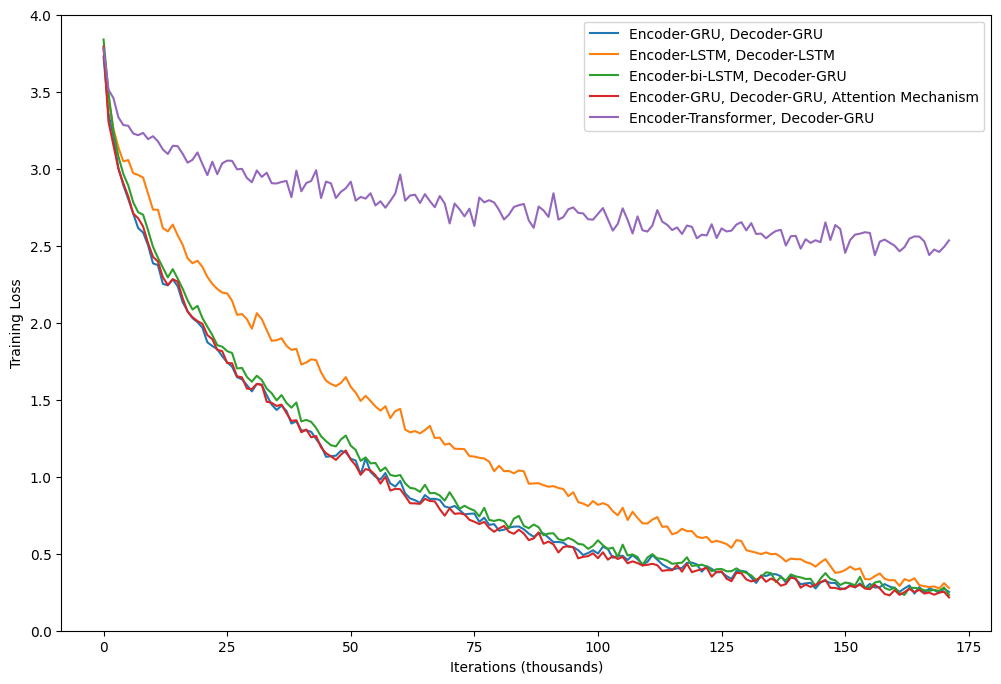

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(task2_losses, label='Encoder-GRU, Decoder-GRU')
plt.plot(task3_losses, label='Encoder-LSTM, Decoder-LSTM')
plt.plot(task4_losses, label='Encoder-bi-LSTM, Decoder-GRU')
plt.plot(task5_losses, label='Encoder-GRU, Decoder-GRU, Attention Mechanism')
plt.plot(task6_losses, label='Encoder-Transformer, Decoder-GRU')
plt.ylim((0,4))
plt.xlabel('Iterations (thousands)')
plt.ylabel('Training Loss')
plt.legend()

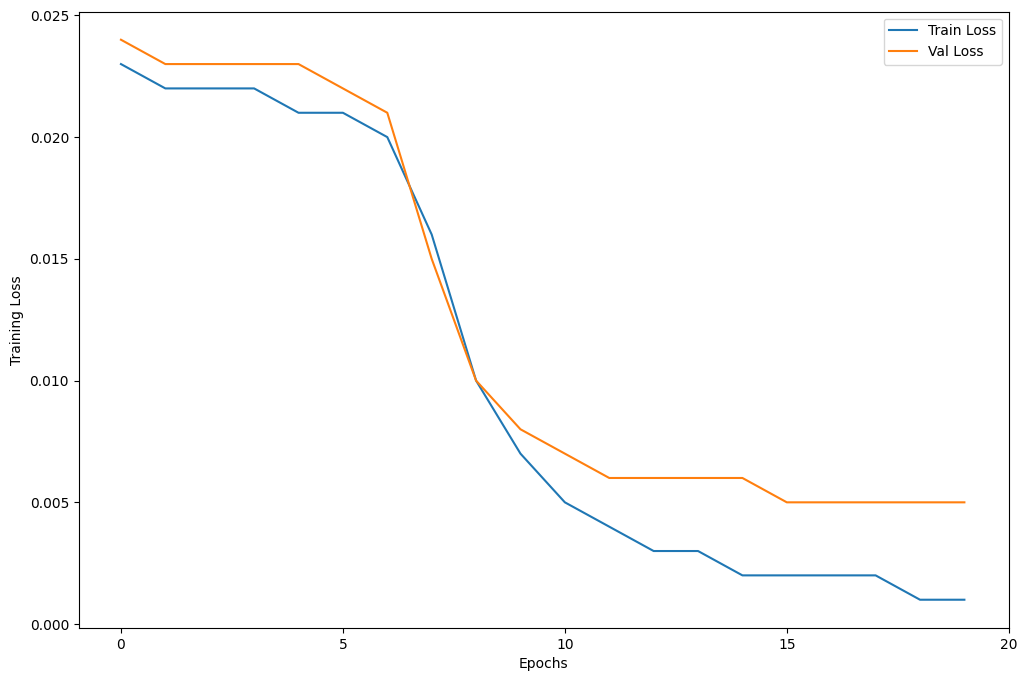

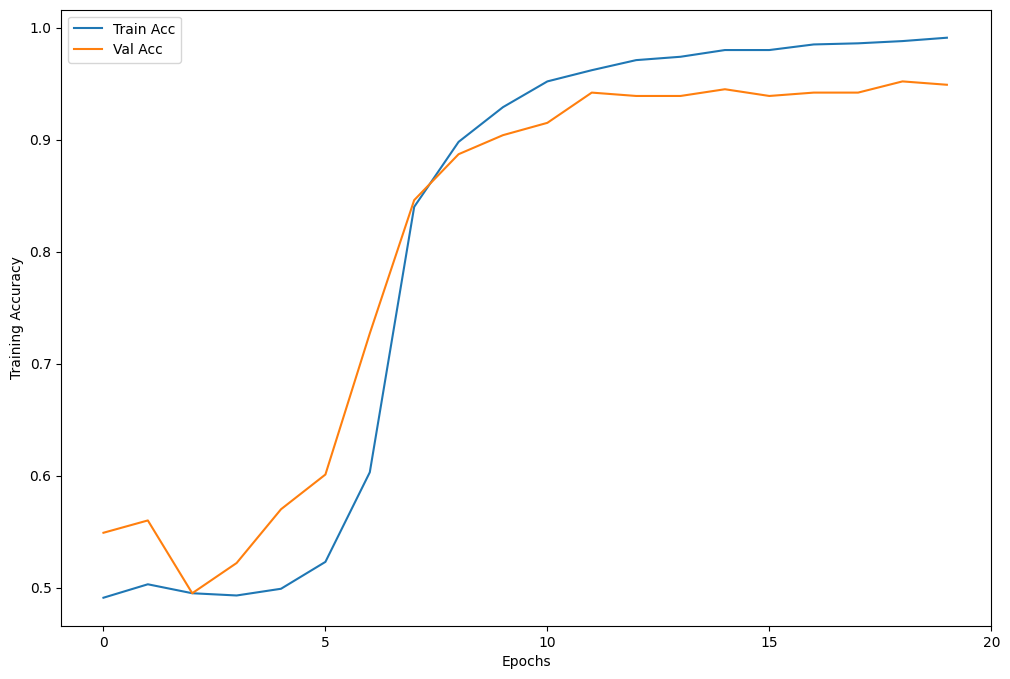

In [ ]:
#########################
train_loss = np.asarray([0.023, 0.022, 0.022, 0.022, 0.021, 0.021, 0.020, 0.016, 0.010, 0.007, 0.005, 0.004, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001])
train_acc = np.asarray([0.491, 0.503, 0.495, 0.493, 0.499, 0.523, 0.603, 0.840, 0.898, 0.929, 0.952, 0.962, 0.971, 0.974, 0.980, 0.980, 0.985, 0.986, 0.988, 0.991])

val_loss = np.asarray([0.024, 0.023, 0.023, 0.023, 0.023, 0.022, 0.021, 0.015, 0.010, 0.008, 0.007, 0.006, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005])
val_acc = np.asarray([0.549, 0.560, 0.495, 0.522, 0.570, 0.601, 0.727, 0.846, 0.887, 0.904, 0.915, 0.942, 0.939, 0.939, 0.945, 0.939, 0.942, 0.942, 0.952, 0.949])

plt.figure(figsize=(12,8))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.xticks(np.arange(0,21,step=5))
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.xticks(np.arange(0,21,step=5))
plt.legend()